# Imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import traceback, warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

from pynistview_utils import *

# Set up directories and files

In [4]:
# Configure input files

indir = "/Users/rmoraski/Documents/iCloud/School/Electrons/NISTView-ish/data/"
sempa_file_suffix = 'sempa'

#name = "191001_Fe_whisker/Fe_whisker"

# name = "FeGd_Nov_Dec/171117_FeGd"
# runs = (2, 3)

name = "FeGd_Nov_Dec/FeGd100"
runs = (6, 7)
# runs = (11, 10)

# name = "FeGd_Nov_Dec/FeGd200"
# runs = (3, 2) # bad
# runs = (5, 6) # also bad

# name = 'alice/171117_FeGd'
# runs = (2, 3)

# name = "FeGd_5x120/20161213"
# runs = (5, 6)
# runs = (8, 9)
# runs = (12, 13)

# Specify the number of features - 1 in the image. This is used to segment and create masks.
segments = 2

# Specify gaussian denoising sigma
sigma = 2

# Specify non-local denoising strength h. Larger h -> more denoising.
h = 20

# Specify a scale for drawing the vector arrows. Smaller number -> longer arrow.
arrow_scale = 0.2

# Specify a color for the vector arrows.
# arrow_color = 'black'
arrow_color = 'white'


# Import files

In [5]:
image_dict = import_files(name, runs, indir)

intensity_1, intensity_1_blurred, intensity_1_flat = image_dict['i1']
intensity_2, intensity_2_blurred, intensity_2_flat = image_dict['i2']

m_1, axis_1, m_1_ydim, m_1_xdim, m_1_min, m_1_max = image_dict['m1']
m_2, axis_2, m_2_ydim, m_2_xdim, m_2_min, m_2_max = image_dict['m2']
m_3, axis_3, m_3_ydim, m_3_xdim, m_3_min, m_3_max = image_dict['m3']
m_4, axis_4, m_4_ydim, m_4_xdim, m_4_min, m_4_max = image_dict['m4']

scale = image_dict['scale']
magnification = image_dict['magnification']

Searching FeGd_Nov_Dec/FeGd100* for runs (6, 7)...
Found files:
['FeGd100006_ix.sempa', 'FeGd100006_iy.sempa', 'FeGd100006_mx.sempa', 'FeGd100006_my.sempa', 'FeGd100007_ix2.sempa', 'FeGd100007_iz.sempa', 'FeGd100007_mx2.sempa', 'FeGd100007_mz.sempa']


# Align scans

Get the 2 ix images aligned as best possible

Found 126 matches; keeping 63.
Top left: [6 9], Top right: [255   6]
Bottom left: [  1 255], Bottom right: [255 255]
Cropping (6, 9) to (255, 255)


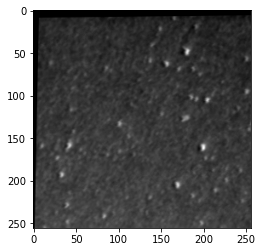

In [6]:
try:
    results_r, results_h, h, imMatches, imKeypoints = align_and_scale(intensity_1, intensity_2, m_1, m_2, m_3, m_4, match_percent=0.5, filter=0)
    intensity_1_r, intensity_2_r, m_1_r, m_2_r, m_3_r, m_4_r = results_r
    intensity_1_h, m_1_h, m_2_h = results_h

    intensity_2_scaled_to_1 = rescale_to(intensity_2_r, intensity_1_r)
    m_4_scaled_to_1 = rescale_to(m_4_r, m_1_r)
    difference_im = intensity_2_scaled_to_1 - intensity_1_r
    difference_mx = m_4_scaled_to_1 - m_1_r

    m_1_r_g_full = rescale_to(gaussian_filter(m_1_r, sigma), m_1_r)
    m_2_r_g_full = rescale_to(gaussian_filter(m_2_r, sigma), m_2_r)
    m_3_r_g_full = rescale_to(gaussian_filter(m_3_r, sigma), m_3_r)
    m_4_r_g_full = rescale_to(gaussian_filter(m_4_r, sigma), m_4_r)
except Exception as ex:
    print()
    print(ex)
    print()
    traceback.print_exc()

# Find offsets

The imaging components do not use the same zero point. Since the magnetization vector should have the same magnitude over the entire sample, minimize the min to max spread across the combined images.

In [7]:
# Eliminate outliers
m_1_r_g, m_2_r_g, m_3_r_g = limit_to(m_1_r_g_full), limit_to(
    m_2_r_g_full), limit_to(m_3_r_g_full)

# Find averages for each image and shift the values
m_1_average = (np.max(m_1_r_g) - np.abs(np.min(m_1_r_g))) / 2
m_2_average = (np.max(m_2_r_g) - np.abs(np.min(m_2_r_g))) / 2
m_3_average = (np.max(m_3_r_g) - np.abs(np.min(m_3_r_g))) / 2

m_1_shifted, m_2_shifted, m_3_shifted = m_1_r_g - m_1_average, \
    m_2_r_g - m_2_average, m_3_r_g - m_3_average

# Optimize the amount of shift necessary by minimizing least squares fitting
(m_1_offset, m_2_offset, m_3_offset), status, message = \
    find_offsets(m_1_shifted, m_2_shifted, m_3_shifted)

m_1_offset_opt, m_2_offset_opt, m_3_offset_opt = \
    m_1_average + m_1_offset, m_2_average + m_2_offset, m_3_average + m_3_offset

m_1_adjusted, m_2_adjusted, m_3_adjusted = \
    m_1_r_g - m_1_offset_opt, m_2_r_g - m_2_offset_opt, m_3_r_g - m_3_offset_opt

m_1_adjusted = m_1_adjusted - fit_image(m_1_adjusted)[0]
m_2_adjusted = m_2_adjusted - fit_image(m_2_adjusted)[0]
m_3_adjusted = m_3_adjusted - fit_image(m_3_adjusted)[0]

# (m_1_offset, m_2_offset, m_3_offset), status, message = find_offsets(m_1_r, m_2_r, m_3_r)
# m_1_adjusted, m_2_adjusted, m_3_adjusted = m_1_r - m_1_offset, m_2_r - m_2_offset, m_3_r - m_3_offset

print('M{} average: {:.4f}, M{} average: {:.4f}, M{} average: {:.4f}'.format(
    axis_1, m_1_average, axis_2, m_2_average, axis_3, m_3_average))
print('M{} offset: {:.4f}, M{} offset: {:.4f}, M{} offset: {:.4f}'.format(
    axis_1, m_1_offset, axis_2, m_2_offset, axis_3, m_3_offset))

print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_1, m_1_min, m_1_max, np.ptp(m_1_adjusted), m_1_adjusted.min(), m_1_adjusted.max()))
print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_2, m_2_min, m_2_max, np.ptp(m_2_adjusted), m_2_adjusted.min(), m_2_adjusted.max()))
print('M{} original range: {:.4f} to {:.4f}; offset range: {:.3f}, {:.4f} to {:.4f}'.format(
    axis_3, m_3_min, m_3_max, np.ptp(m_3_adjusted), m_3_adjusted.min(), m_3_adjusted.max()))

MX average: 0.0673, MY average: -0.5061, MZ average: 0.0779
MX offset: 0.0596, MY offset: -0.0464, MZ offset: -0.0901
MX original range: 1.1648 to 1.3357; offset range: 0.136, -0.0673 to 0.0687
MY original range: -0.5950 to -0.4314; offset range: 0.132, -0.0720 to 0.0601
MZ original range: -0.0573 to 0.2185; offset range: 0.145, -0.0716 to 0.0729


# Calculate magnitudes and angles, find contours

In [8]:
# Calculate magnitudes and angles
magnitudes = get_magnitudes(m_1_adjusted, m_2_adjusted, m_3_adjusted)
magnitudes /= magnitudes.max()
max_dev = np.std(magnitudes)
# upper_limit = magnitudes.mean() + 3 * max_dev
# magnitudes = np.where(magnitudes < upper_limit, magnitudes, upper_limit)

phis, thetas = get_phases(m_1_adjusted, m_2_adjusted, m_3_adjusted)
phis_rgba = render_phases_and_magnitudes(phis, magnitudes)

# Apply a light gaussian filter to clean up the images
magnitudes_flattened = rescale_to(gaussian_filter(magnitudes, 2), [0, 1])
phis_flattened = rescale_to(gaussian_filter(phis, 3), phis)
thetas_flattened = rescale_to(gaussian_filter(thetas, 3), thetas)
phis_flattened_rgba = render_phases_and_magnitudes(
    phis_flattened, magnitudes_flattened)

# Find circular features in the Z direction
circular_contours, contours_g, contours = find_circular_contours(
    thetas_flattened)

mag_low, mag_high = np.percentile(
    magnitudes_flattened, 5), np.percentile(magnitudes_flattened, 95)

# Calculate 2D values as well
magnitudes_2d = get_magnitudes(m_1_adjusted, m_2_adjusted)
magnitudes_2d /= magnitudes_2d.max()
max_dev = np.std(magnitudes_2d)
upper_limit = magnitudes_2d.mean() + 3 * max_dev
magnitudes_2d_trimmed = np.where(
    magnitudes_2d < upper_limit, magnitudes_2d, upper_limit)
magnitudes_2d_flattened = rescale_to(
    gaussian_filter(magnitudes_2d_trimmed, 3), [0, 1])

phis_2d, _ = get_phases(m_1_adjusted, m_2_adjusted)

print('Magnitudes range from {:.4f} to {:.4f} with mean {:.4f}, stddev {:.4f}, and 90% confidence interval {:.4f}..{:.4f}'.format(
    magnitudes_flattened.min(), magnitudes_flattened.max(), magnitudes_flattened.mean(), max_dev, mag_low, mag_high))
print(f'\N{greek small letter phi} ranges from {phis_flattened.min():.4f} to {phis_flattened.max():.4f}')
print(f'\N{greek small letter theta} ranges from {thetas_flattened.min():.4f} to {thetas_flattened.max():.4f}')
print(
    f'Found {len(circular_contours)} circular contours, {len(contours_g)} contours not on the edge, out of {len(contours)} total.')


Magnitudes range from 0.0000 to 1.0000 with mean 0.2951, stddev 0.1201, and 90% confidence interval 0.1486..0.4647
φ ranges from 0.0001 to 6.2831
θ ranges from 0.0062 to 3.1389
Found 34 circular contours, 68 contours not on the edge, out of 74 total.


# LTEM data

In [9]:
# ltem_data_name = 'img005_alpha05.npy'
# ltem_data_name = 'img006_alpha05_OL0000.npy'
# ltem_data_name = '00_B.npy'
# ltem_data_name = 'n50_B.npy'
ltem_data_name = 'inductions2.npz'
ltem_data_path = indir + 'will/' + ltem_data_name


In [10]:

ltem_phases, ltem_magnitudes, ltem_circular_contours, ltem_contours_g, ltem_alphas, ltem_xerror, ltem_yerror = process_ltem_data(ltem_data_path)
# Rotate phase data by 90º, staying within 0..2 pi
# ltem_phases = np.where(ltem_phases >= 3/2 * np.pi, ltem_phases - 3/2 * np.pi, ltem_phases + np.pi / 2)

alphas_ltem = ltem_alphas[:, 2]

ltem_boxes = get_bounding_boxes(ltem_circular_contours)
ltem_box_widths = np.asarray(ltem_boxes)[:, 2]

print(f'\N{greek small letter sigma} for ltem_alpha = {np.std(ltem_alphas[:, 2]):.3f}')

σ for ltem_alpha = 0.256


# Magnitude and phase sanity checks

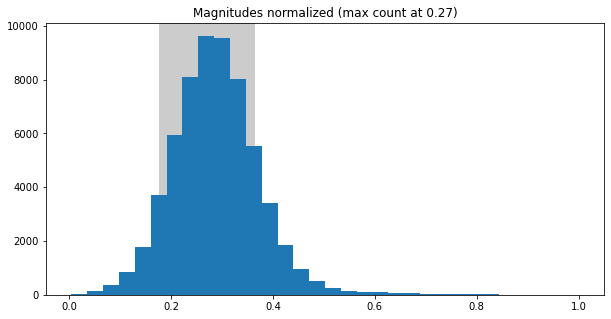

In [11]:
show_magnitude_distribution(magnitudes)

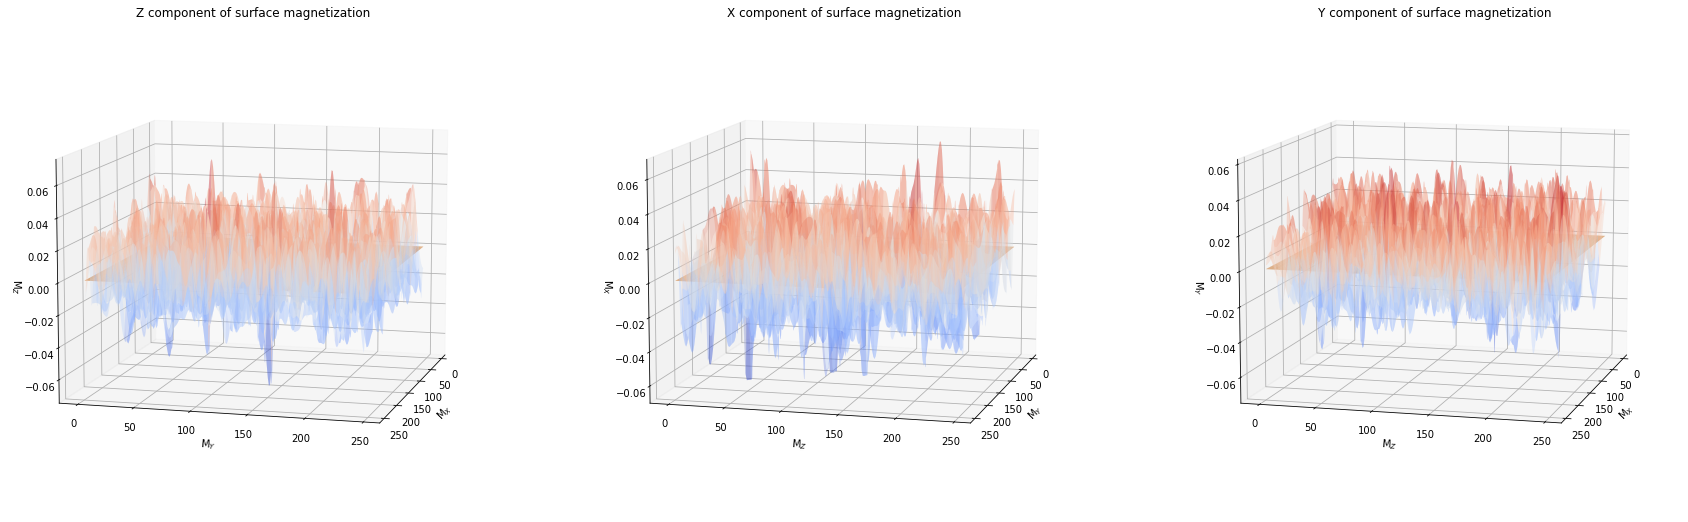

In [12]:
show_magnetization_components(magnitudes, m_1_adjusted, m_2_adjusted, m_3_adjusted, axis_1, axis_2, axis_3)

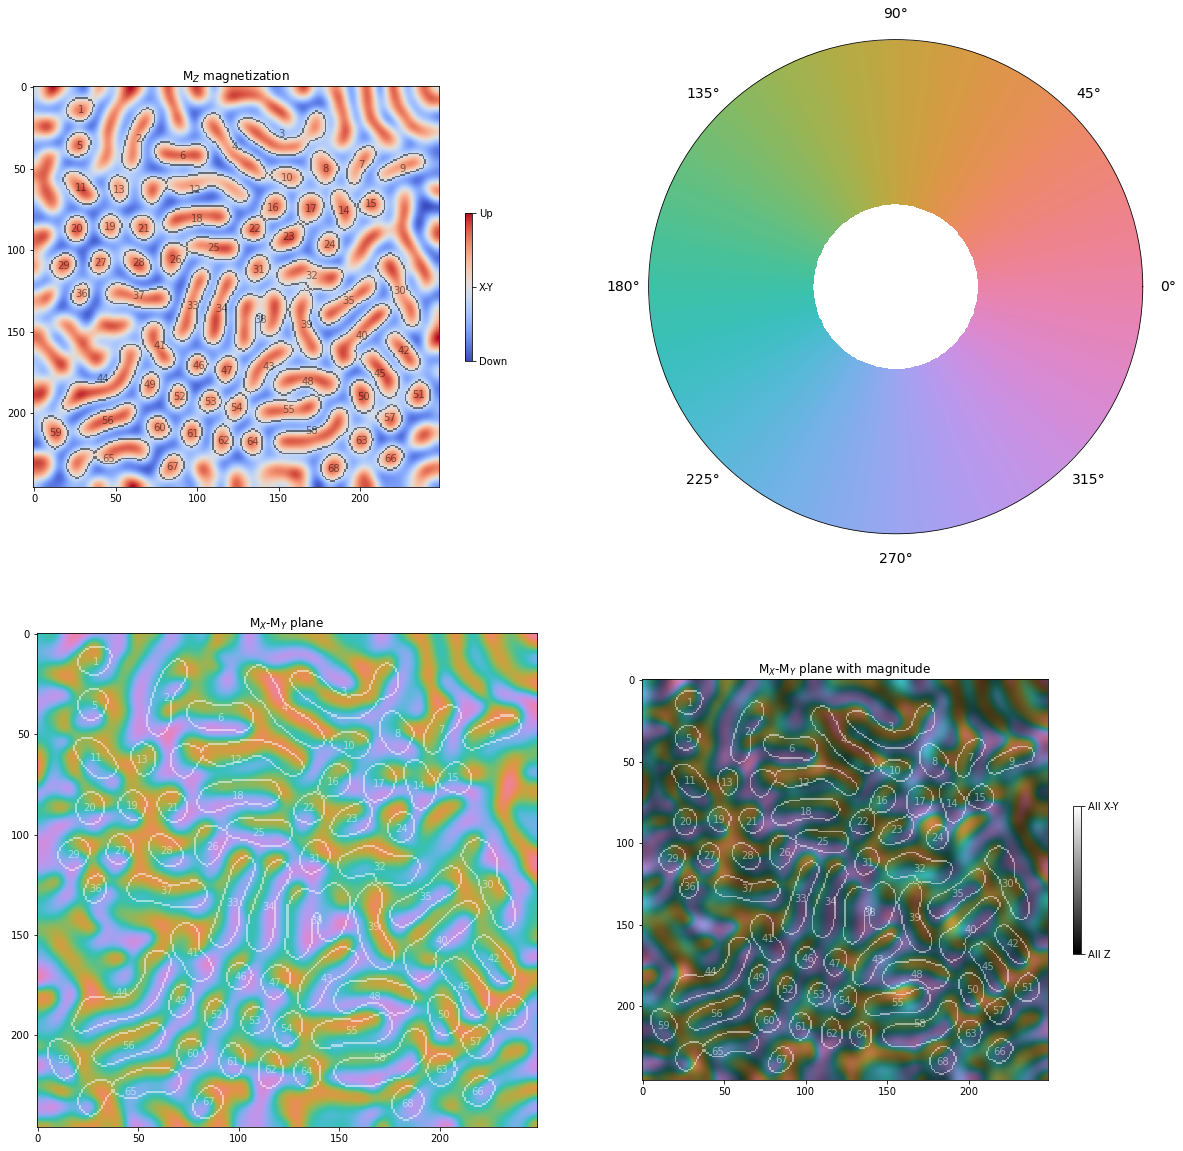

In [13]:
show_contours_overview(thetas_flattened, phis_flattened, contours_g, magnitudes_2d_flattened, axis_1, axis_2, axis_3)

# Contour plots

Found 34 boxes.
Of 34 circular feature(s) total, 17 have deviations ≤ pi/6 (0.52)
Indices are [2, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30]
Index [20] is the best match


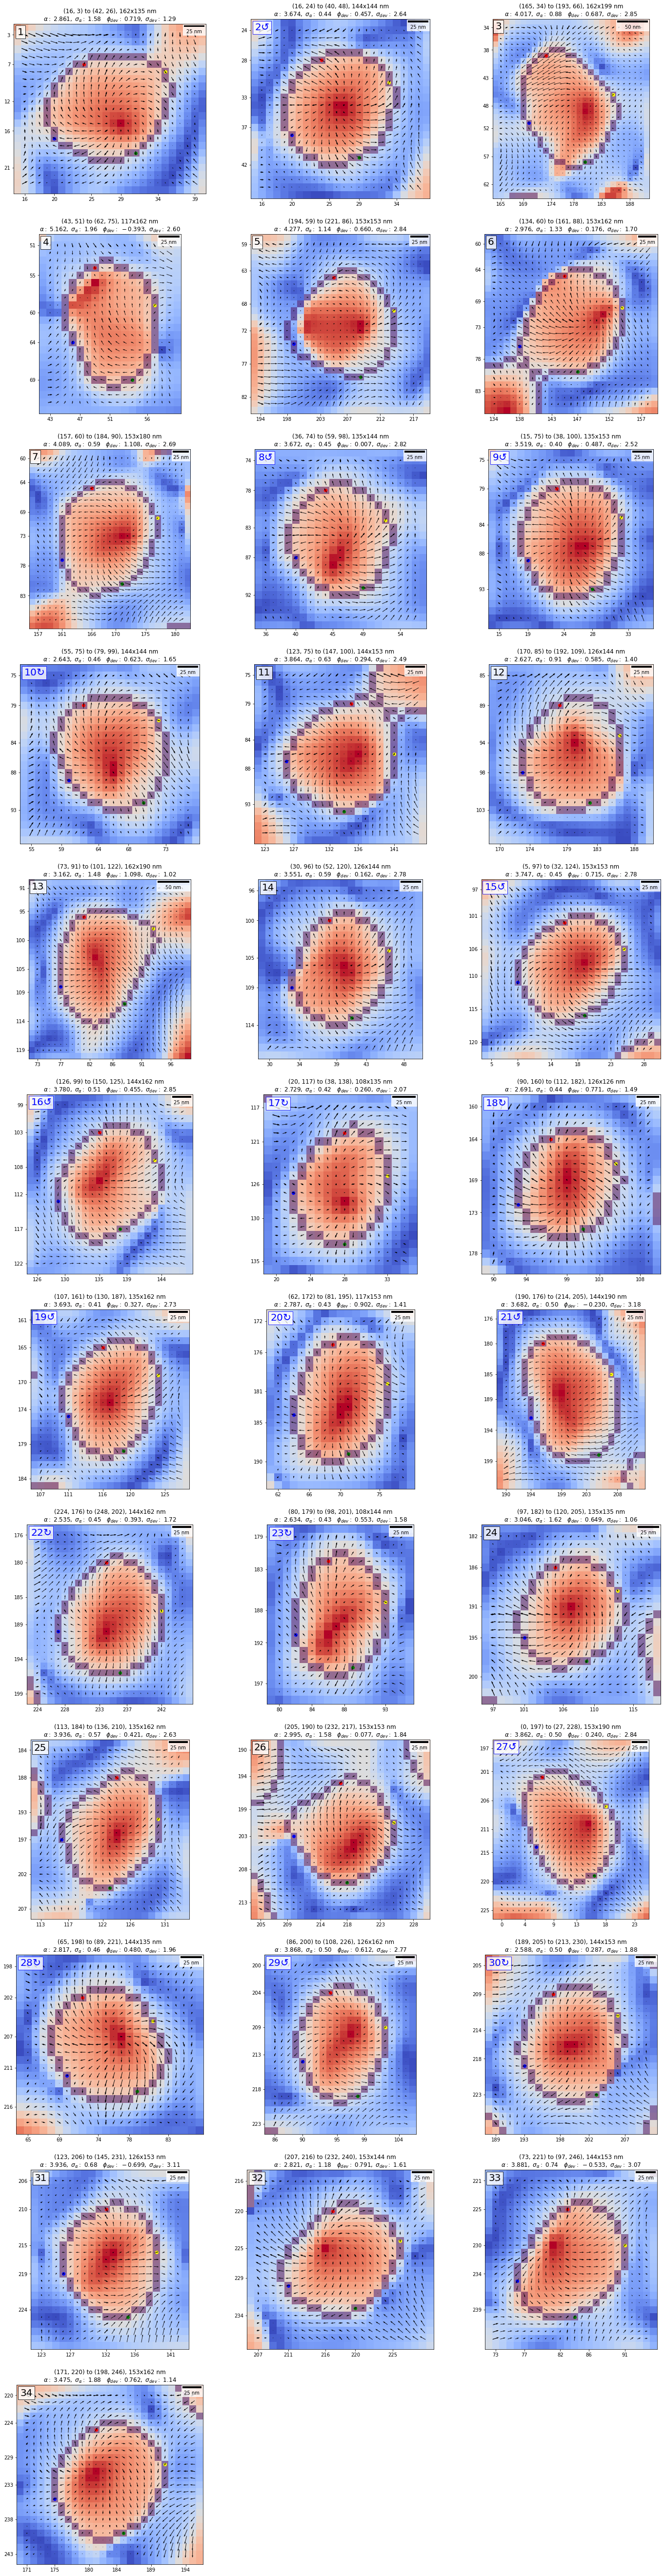

In [14]:
candidates, all_contours = show_circles(magnitudes_flattened, phis, thetas, circular_contours, scale,
                                        phis_m=phis_flattened_rgba, normalize=False,
                                        show_numbers=True, show_axes=True, show_title=True,
                                        just_candidates=False)

indices = list(candidates.keys())
alphas_candidates = [c[2] for c in list(candidates.values())]
alphas_all = [c[2] for c in list(all_contours.values())]

error = scale * 1e8
sizes = [(c[4], c[5]) for c in list(candidates.values())]
widths, heights = zip(*sizes)
print(f'Of {len(circular_contours)} circular feature(s) total, {len(indices)} have deviations ≤ pi/6 ({np.pi / 6:.2f})')

if len(indices) > 0:
    print(f'Indices are {indices}')
    values = np.array(list(candidates.values()))
    best_std = np.min(values[:, 1])
    best_index = [index for index, details in candidates.items()
                  if details[1] == best_std]
    print(f'Index {best_index} is the best match')


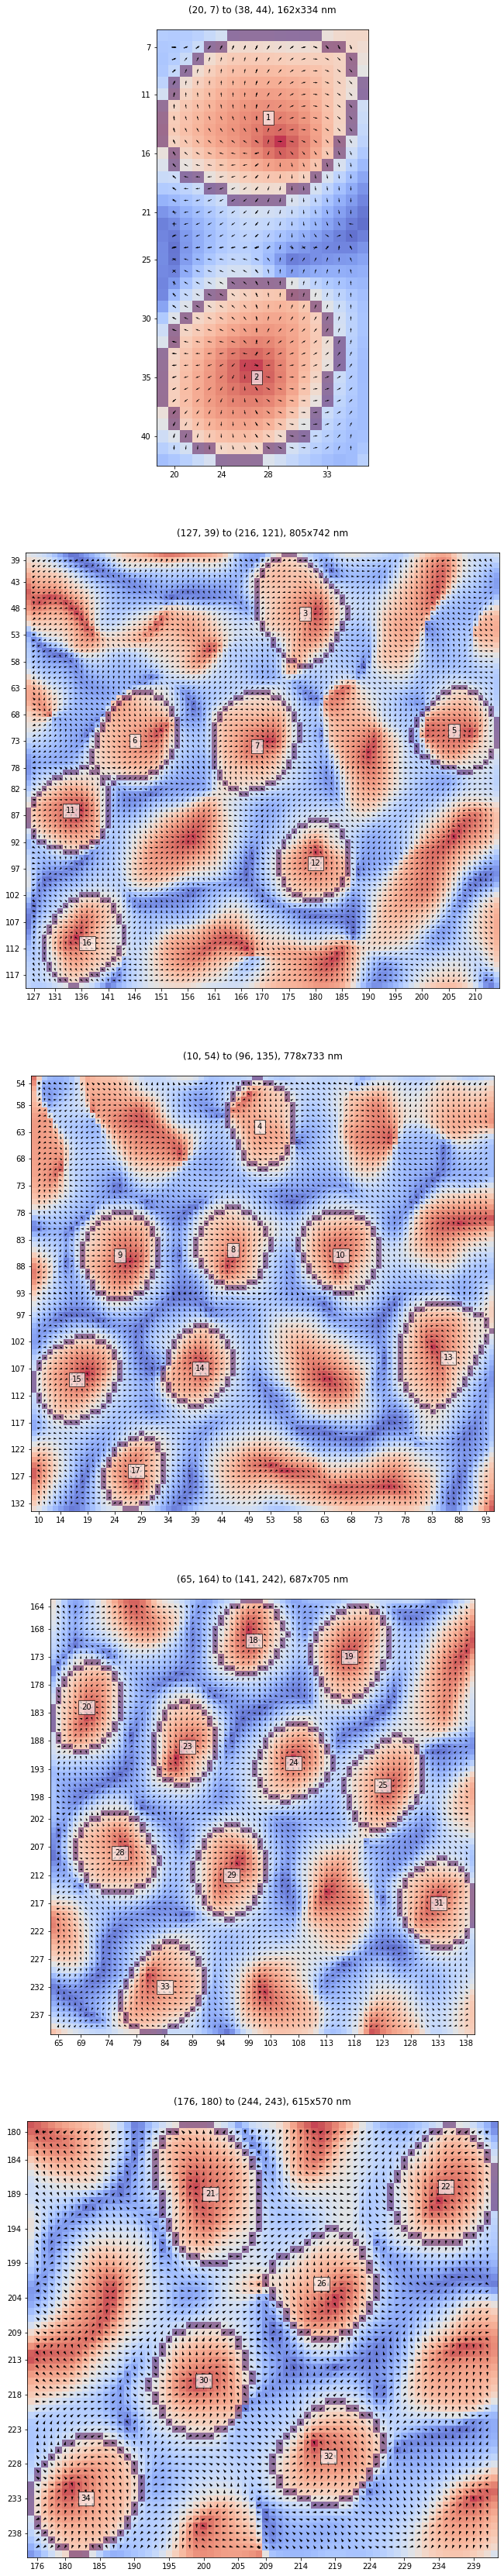

In [15]:
show_groups(circular_contours, magnitudes, phis, thetas, scale)

# LTEM plots

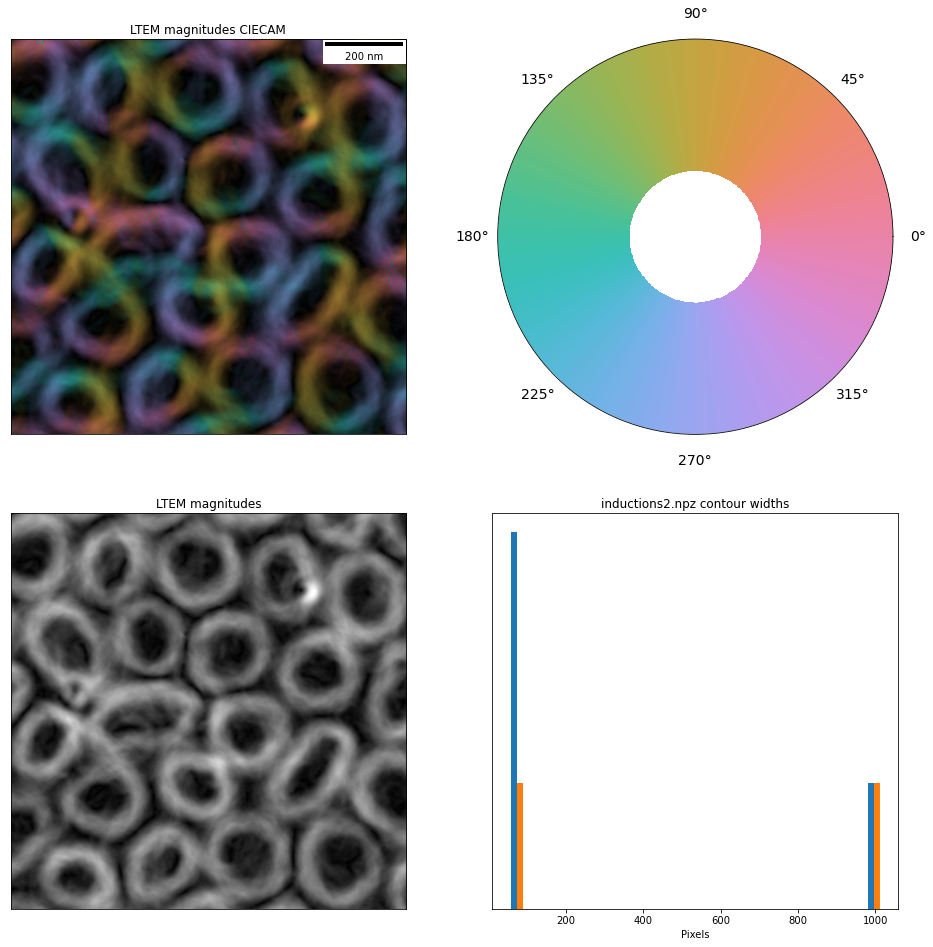

In [16]:
show_ltem_data(ltem_magnitudes, ltem_phases, ltem_circular_contours,
               ltem_box_widths, ltem_xerror, ltem_yerror, ltem_data_name, use_cutoff=True)

In [17]:
size = 600
ydim, xdim = ltem_magnitudes.shape
ylow, yhigh, xlow, xhigh = (
    ydim - size) // 2, (ydim + size) // 2, (xdim - size) // 2, (xdim + size) // 2

ltem_magnitudes_center = ltem_magnitudes[ylow:yhigh, xlow:xhigh]
ltem_phases_center = ltem_phases[ylow:yhigh, xlow:xhigh]

cc, c_g, c = find_circular_contours(
    ltem_magnitudes_center, diff_axes_threshold=0.4)
cc_lim = [c for c in cc if len(c) > 0.05 * size and len(c) < 0.4 * size]
cc_lim = [scale_contour(c, 1.3) for c in cc_lim]
cc_lim = [c for c in cc_lim
          if np.min(c) >= 0 and np.max(c) < size]

alphas_ltem = np.asarray([get_phi_diff(np.squeeze(c), ltem_phases_center)
                          for c in cc_lim])[:, 2]
# alphas_ltem = ltem_alphas[:, 2]
print(
    f'\N{greek small letter sigma} for ltem_alpha = {np.std(alphas_ltem):.3f}')


σ for ltem_alpha = 0.173


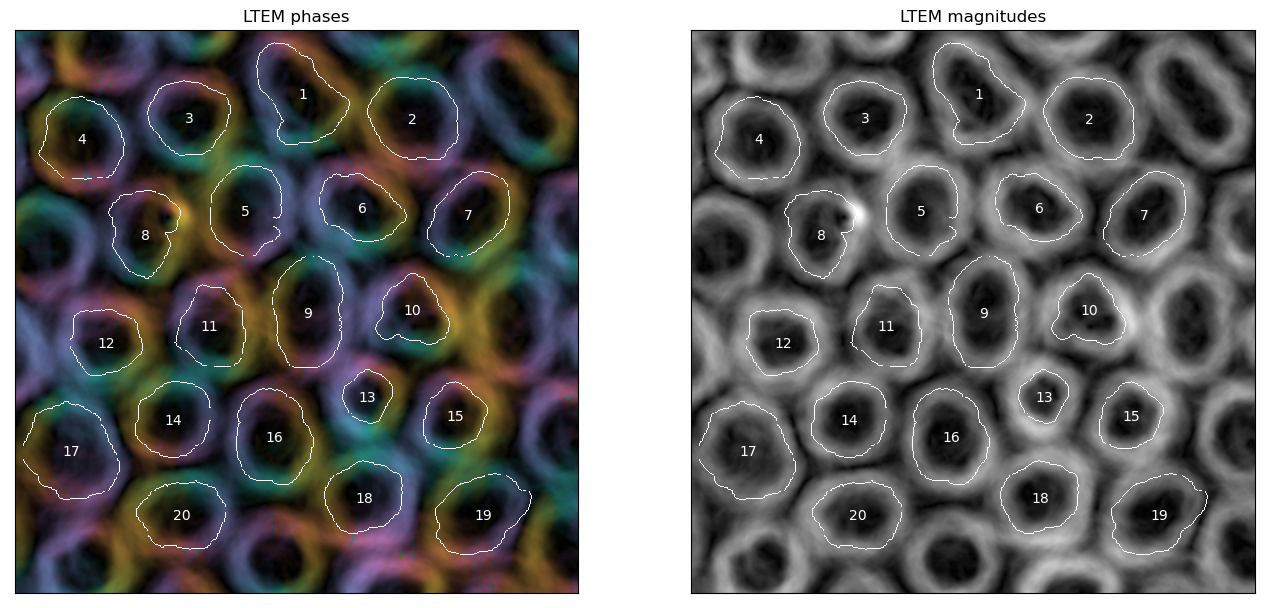

In [23]:
plt.style.use('default')
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax1.imshow(np.zeros_like(ltem_phases_center), cmap='gray')
ax1.imshow(ltem_phases_center, alpha=ltem_magnitudes_center / ltem_magnitudes_center.max(), cmap=ciecam02_cmap())
show_all_circles(ltem_magnitudes_center, cc_lim, ax1, color='white')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('LTEM phases')

ax2 = fig.add_subplot(122)
ax2.imshow(ltem_magnitudes_center, cmap='gray')
show_all_circles(ltem_magnitudes_center, cc_lim, ax2, color='white')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('LTEM magnitudes');

# Alpha plots

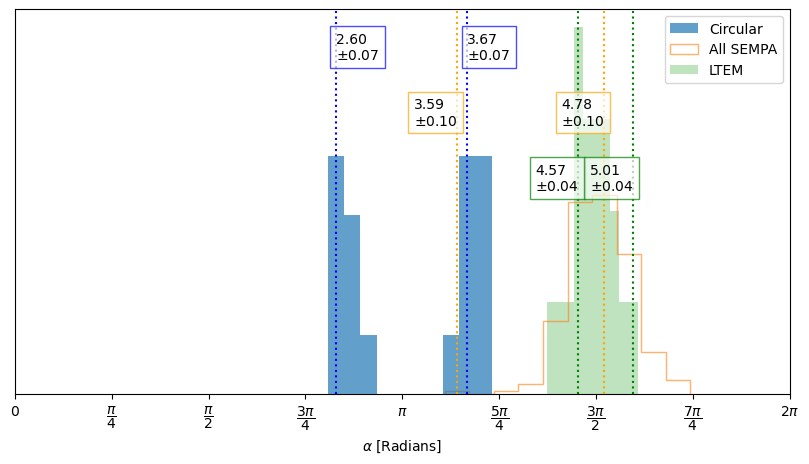

In [19]:
show_alphas_2(alphas_candidates, ltem_alphas[:, 2], alphas_ltem, show_all=True)


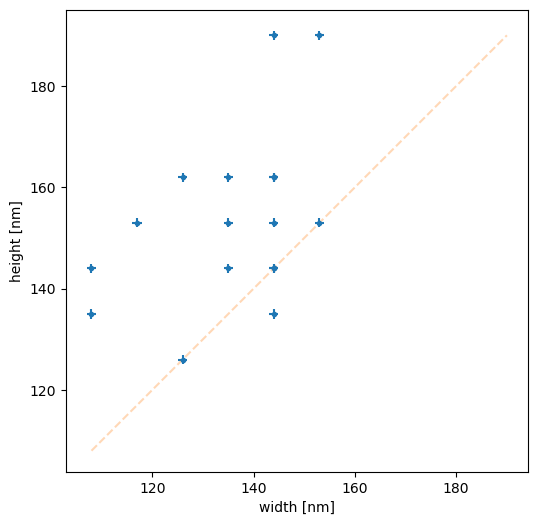

In [20]:
show_contour_sizes(widths, heights, error, error)

# Save results